In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv('/content/utkface_sortAge.csv')
df.drop(['Unnamed: 0', 'ethnicity'], axis = 1, inplace = True)
df

,age,gender,image
0,1,0,83 91 120 87 95 124 95 103 132 106 114 143 111...
1,1,1,109 127 150 112 129 155 118 134 162 98 114 143...
2,1,0,10 13 34 14 18 40 26 31 56 40 47 74 56 64 90 6...
3,1,0,18 28 39 21 30 44 37 46 61 68 76 93 75 85 103 ...
4,1,1,90 129 173 95 134 178 99 138 182 103 142 186 1...
...,...,...,...
23703,99,1,91 111 128 102 125 141 123 148 164 142 168 184...
23704,99,1,103 122 148 74 95 126 63 85 127 47 71 118 40 6...
23705,99,1,20 25 24 24 29 28 28 33 32 31 36 35 36 41 40 4...
23706,99,1,118 142 194 121 149 200 117 149 200 120 156 20...


In [3]:
df.age.unique(), df.gender.unique()

(array([  1,  10, 100, 101, 103, 105,  11, 110, 111, 115, 116,  12,  13,
         14,  15,  16,  17,  18,  19,   2,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,   3,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,   4,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,
          5,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,   6,  60,
         61,  62,  63,  64,  65,  66,  67,  68,  69,   7,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,   8,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,   9,  90,  91,  92,  93,  95,  96,  99]),
 array([0, 1]))

____ Fix data error in ethnicity ____

In [4]:
df1 = df.copy()

In [ ]:
df1 = df1.loc[(df1.ethnicity == '0') | (df1.ethnicity == '1') | (df1.ethnicity == '2') | (df1.ethnicity == '3') | (df1.ethnicity == '4')]
df1.ethnicity.unique()

array(['0', '3', '2', '4', '1'], dtype=object)

In [ ]:
X = np.array(df1['image'].to_list())
X_reshaped1 = X.reshape(X.shape[0], 50, 50, 3)
X_reshaped1.shape

In [ ]:
X_reshaped1 = X_reshaped1 / 255

In [8]:
df.describe()

,age,gender
count,23708.000000,23708.000000
mean,33.303484,0.477349
std,19.886112,0.499497
min,1.000000,0.000000
25%,23.000000,0.000000
50%,29.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


<ipython-input-9-32bba7c528dc>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['age']);


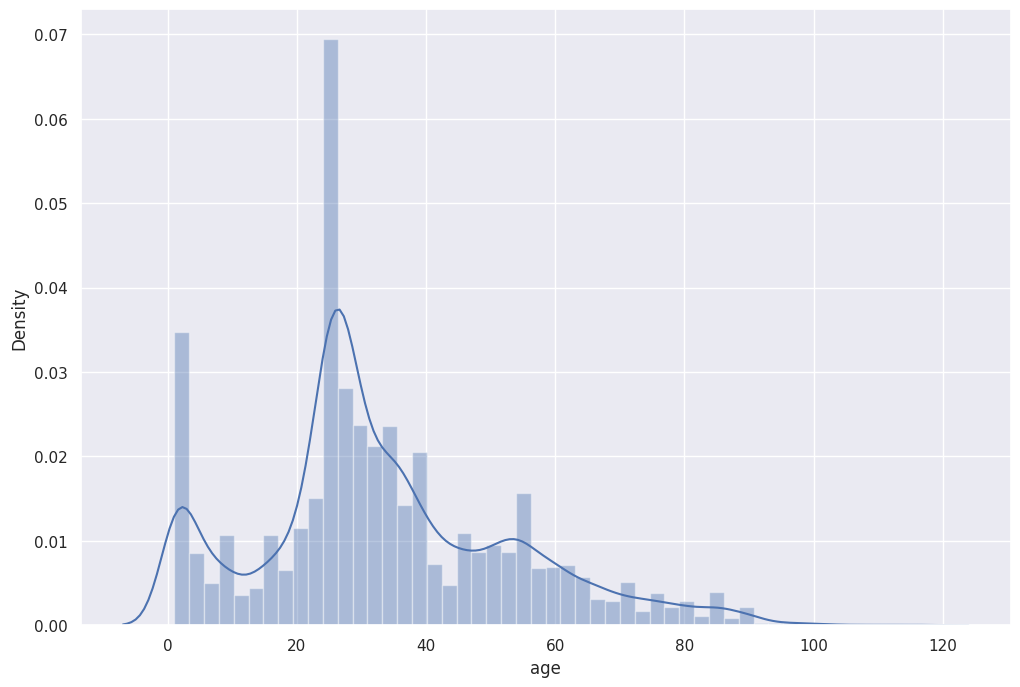

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(df['age']);

In [10]:
df.age.value_counts()

,count
age,
26,2197
1,1123
28,918
35,880
24,859
...,...
115,3
101,2
91,2


In [14]:
df['image'] = df['image'].map(lambda x: np.array(x.split(' '), dtype=np.uint8).reshape(50, 50, 3))

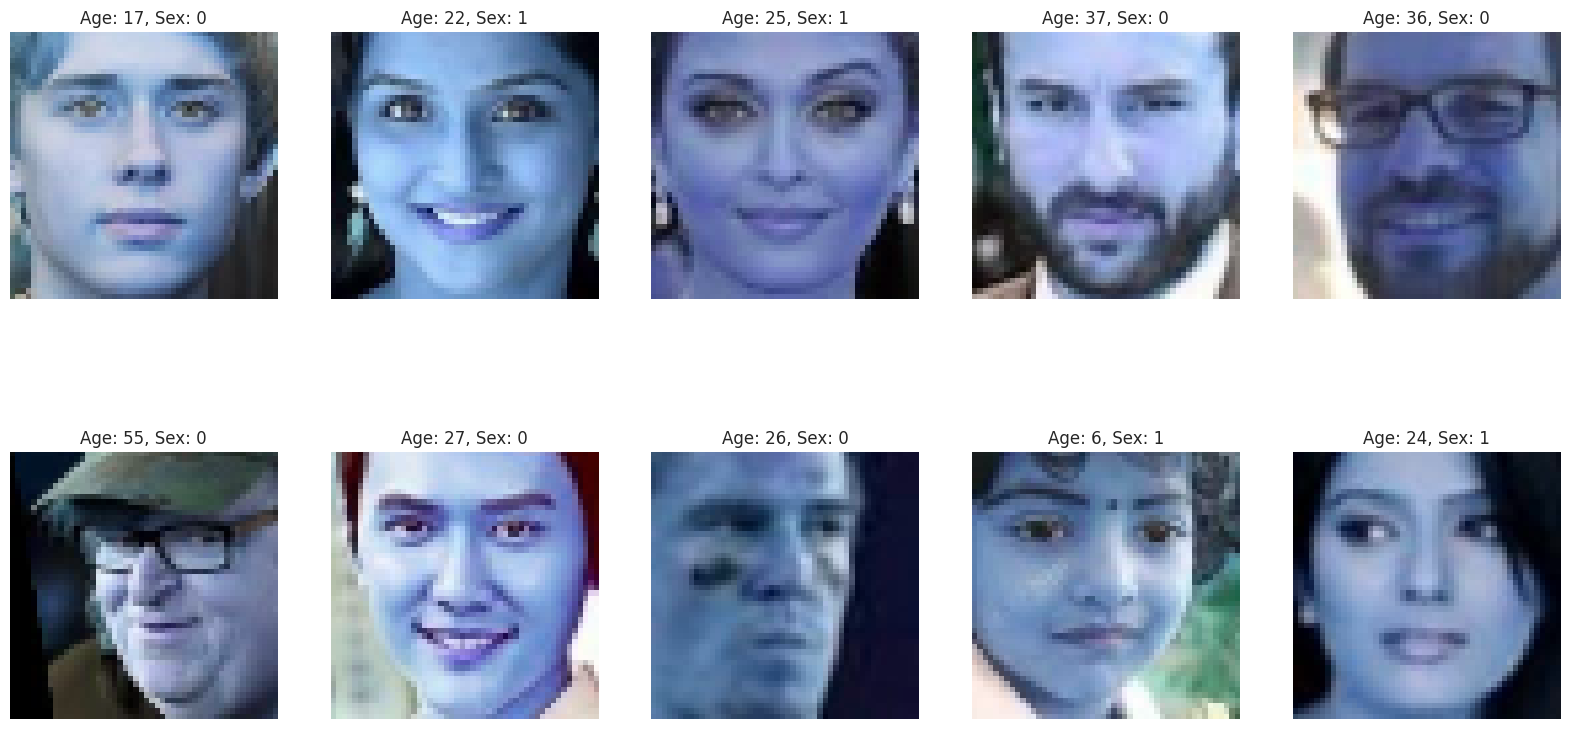

In [16]:
# Plot some pictures
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(2):
    for j in range(5):
        random_face = np.random.choice(len(df))

        age = df['age'][random_face]
        # ethnicity = df['ethnicity'][random_face]
        gender = df['gender'][random_face]

        axes[i][j].set_title('Age: {0}, Sex: {1}'.format(age, gender))
        axes[i][j].imshow(df['image'][random_face], cmap='gray')
        axes[i][j].axis('off')

# Age prediction¶


In [17]:
X = np.array(df['image'].to_list())
X_reshaped = X.reshape(X.shape[0], 50, 50, 3)
X_reshaped.shape

(23708, 50, 50, 3)

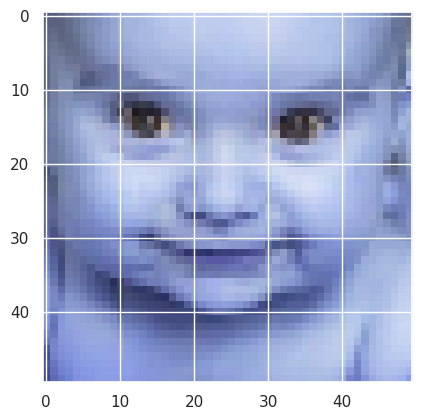

In [18]:
plt.imshow(X_reshaped[0])

In [19]:
X_reshaped = X_reshaped / 255

In [20]:
input_shape = X_reshaped.shape[1:]
input_shape

(50, 50, 3)

In [21]:
y = df['age'].values

In [22]:
# Train test split
X_train, X_testval, y_train, y_testval = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14224, 50, 50, 3),
 (14224,),
 (5690, 50, 50, 3),
 (5690,),
 (3794, 50, 50, 3),
 (3794,))

In [25]:
# Import Library
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Activation,Flatten
from keras.layers import Lambda, Input, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from keras import regularizers

In [26]:
# Data Generator
datagen = ImageDataGenerator(rotation_range = 10,
                             width_shift_range = 0.05,
                             height_shift_range = 0.05,
                             shear_range = 0.05,
                             zoom_range = 0.1,
#                              brightness_range = [0.9,1.1],
                             horizontal_flip = True)
datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

# Convert data gen
seed = 42
train_generator= datagen.flow(X_train, y_train,
                              batch_size = 128,
                              shuffle = True,
                              seed = seed)
val_generator= datagen_val.flow(X_val, y_val,
                                batch_size = 64,
                                shuffle = True,
                                seed = seed)

In [29]:
# Algorithms
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)
# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model.keras', monitor = 'val_loss', verbose = 1, mode = 'min',  save_best_only = True)
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1)


<ipython-input-31-e297e709b0e1>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mbnv2 = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 50, 50, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 25, 25, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 25, 25, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 25, 25, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 25, 25, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 25, 25, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 25, 25, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 25, 25, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 25, 25, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 25, 25, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 25, 25, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 25, 25, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 27, 27, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 13, 13, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,078,209 (11.74 MB)

 Trainable params: 3,044,097 (11.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 395.2692
Epoch 1: val_loss improved from inf to 1722.84839, saving model to best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 98s 427ms/step - loss: 392.8454 - val_loss: 1722.8484 - learning_rate: 0.0010
Epoch 2/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 164.6713
Epoch 2: val_loss did not improve from 1722.84839
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - loss: 164.6360 - val_loss: 3458.7817 - learning_rate: 0.0010
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 146.6277
Epoch 3: val_loss improved from 1722.84839 to 1426.10754, saving model to best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - loss: 146.5787 - val_loss: 1426.1075 - learning_rate: 0.0010
Epoch 4/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 129.1735
Epoch 4: val_loss improved from 1426.10754 to 1247.94824, saving model to best_model.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 129.1437 - val_loss: 1247.9482 - le

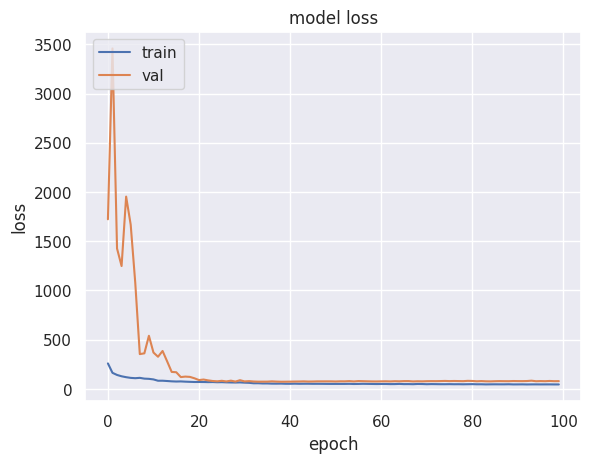

In [31]:
# Import Model
# MobileNetV2 - 14MB - 71.3% - 90.1% - 3.5M - 105
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
mbnv2 = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
# Definition Model
def build_model(base_modelx):
    # Instead of initializing with base_modelx directly, use its output as input to a new Sequential model
    inputs = base_modelx.input
    x = base_modelx.output # Get the output of the base model
    x = GlobalMaxPooling2D()(x)
    x = Flatten()(x)

    x = Dense(512,activation ='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.1)(x)

    x = Dense(256,activation ='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)

    x = Dense(128,activation ='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs) # Create the Functional model
    print(model.summary())
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model(mbnv2)

#Model Trainning
history = model.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks = [checkpoint, reduce_lr])
# history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 100, callbacks = [checkpoint, reduce_lr])

# Ploting acc and loss
from matplotlib import pyplot as plt
# #  "Accuracy"
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

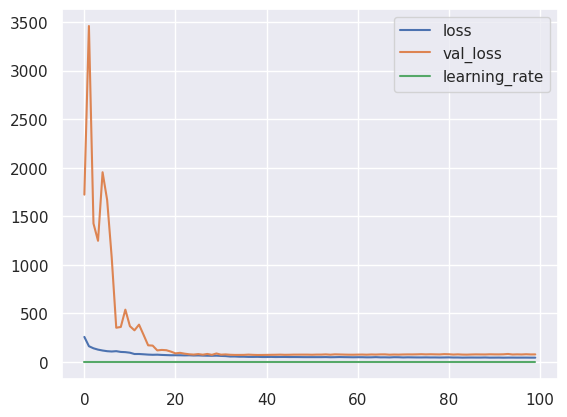

In [32]:
pd.DataFrame(history.history).plot();
plt.savefig('/content/MSE_loss_age.png')

In [33]:
valid_score = model.evaluate(X_test, y_test, verbose=1)
valid_score

119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 78.5289


75.8709945678711

In [34]:
y_pred = np.round(model.predict(X_test))
y_pred


119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


array([[48.],
       [22.],
       [51.],
       ...,
       [37.],
       [61.],
       [26.]], dtype=float32)

In [35]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.943858724301529



# Gender prediction¶


In [36]:
y = df['gender'].values
# Train test split
X_train, X_testval, y_train, y_testval = train_test_split(X_reshaped, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.4, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((14224, 50, 50, 3),
 (14224,),
 (5690, 50, 50, 3),
 (5690,),
 (3794, 50, 50, 3),
 (3794,))

In [37]:
# Data Generator
datagen = ImageDataGenerator(rotation_range = 10,
                             width_shift_range = 0.05,
                             height_shift_range = 0.05,
                             shear_range = 0.05,
                             zoom_range = 0.1,
#                              brightness_range = [0.9,1.1],
                             horizontal_flip = True)
datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

# Convert data gen
seed = 42
train_generator= datagen.flow(X_train, y_train,
                              batch_size = 128,
                              shuffle = True,
                              seed = seed)
val_generator= datagen_val.flow(X_val, y_val,
                                batch_size = 64,
                                shuffle = True,
                                seed = seed)

In [39]:
# Algorithms
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)
# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model_gender.keras', monitor = 'val_loss', verbose = 1, mode = 'min',  save_best_only = True)
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.00001, mode = 'min', verbose = 1)


<ipython-input-43-cf746ac4cc42>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mbnv2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 50, 50, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 25, 25, 32)     │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 25, 25, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 25, 25, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 25, 25, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 25, 25, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 25, 25, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 25, 25, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 25, 25, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 25, 25, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 25, 25, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 25, 25, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 27, 27, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 13, 13, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,078,209 (11.74 MB)

 Trainable params: 3,044,097 (11.61 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6973 - loss: 8.5216
Epoch 1: val_loss improved from inf to 3.56943, saving model to best_model_gender.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 387ms/step - accuracy: 0.6981 - loss: 8.4915 - val_accuracy: 0.6286 - val_loss: 3.5694 - learning_rate: 0.0010
Epoch 2/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8633 - loss: 0.8835
Epoch 2: val_loss improved from 3.56943 to 1.99110, saving model to best_model_gender.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.8634 - loss: 0.8801 - val_accuracy: 0.7337 - val_loss: 1.9911 - learning_rate: 0.0010
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8797 - loss: 0.3995
Epoch 3: val_loss improved from 1.99110 to 0.91537, saving model to best_model_gender.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8797 - loss: 0.3992 - val_accuracy: 0.7698 - val_loss: 0.9154 - learning_rate: 0.0010
Epoch 4/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 

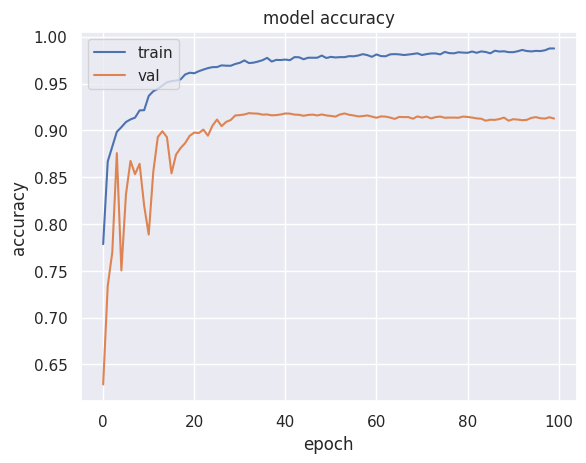

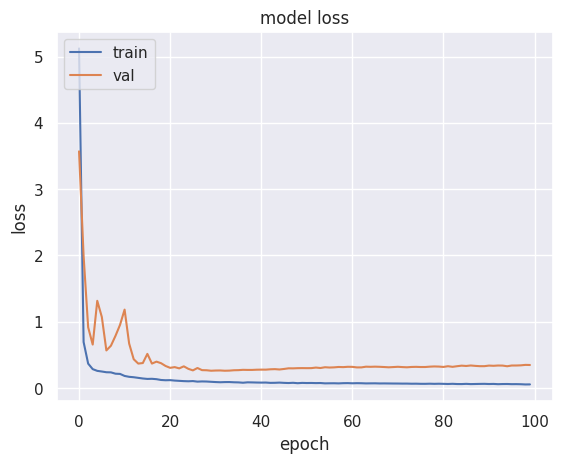

In [43]:
# Import Model
# MobileNetV2 - 14MB - 71.3% - 90.1% - 3.5M - 105
from tensorflow.keras.applications import MobileNetV2, EfficientNetB3
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

mbnv2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Definition Model
def build_model(base_modelx):
    # Get the output of the base model
    x = base_modelx.output

    # Add your layers on top
    x = GlobalMaxPooling2D()(x)  # Use functional API syntax
    x = Flatten()(x)  # Use functional API syntax

    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.1)(x)

    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)

    x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(x)

    # Create the new model
    model = Model(inputs=base_modelx.input, outputs=x)

    print(model.summary())
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(mbnv2)

#Model Trainning
history = model.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks = [checkpoint, reduce_lr])
# history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 64, epochs = 100, callbacks = [checkpoint, reduce_lr])

# Ploting acc and loss
from matplotlib import pyplot as plt
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

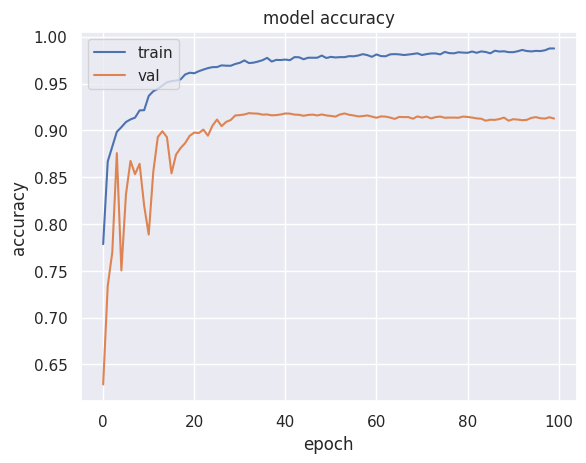

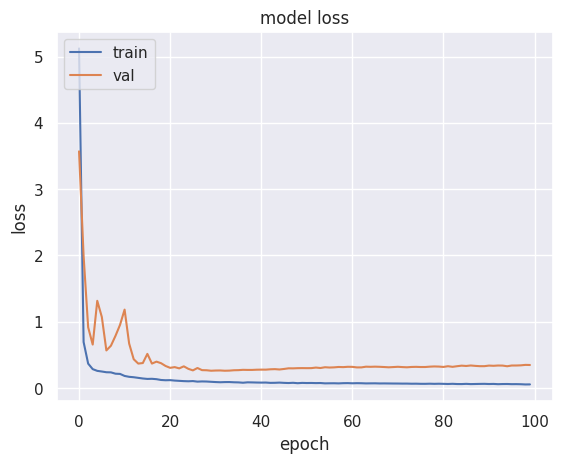

In [44]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/Accuracy_gender.png')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/Loss_gender.png')
plt.show()

In [45]:
valid_score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

119/119 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9247 - loss: 0.3225
Accuracy for test set: 0.9230363965034485


In [46]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
y_pred

119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [47]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1970
           1       0.92      0.92      0.92      1824

    accuracy                           0.92      3794
   macro avg       0.92      0.92      0.92      3794
weighted avg       0.92      0.92      0.92      3794



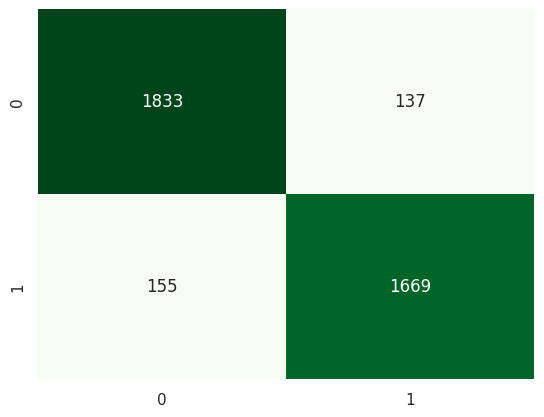

In [48]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d');